In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import cmocean as cmx

import scipy.interpolate as sint

from multiprocess import Pool
import tqdm

rnd = np.random.default_rng()
nproc = 8

### Load in the data
First, defifne which of the models you want to use (e.g. Model I and Model II as ModelI and ModelII, repsectively). From this it computes the Av extinction using the same scaling as in 3D-PDR.

The 3D-PDR data are loaded, too. This consistents of a 2D grid of density and Av. The model here uses an external UV field of 1 Draine and a cosmic ray ionization rate of 1e-17 s-1. There are a total of 601 PDR models, each consisting of 165 Av points. This model is interpolated to get the brightness temperatures for C+, C and CO lines.

In [2]:
model = "ModelI"

densDat = np.load("data/%sGravDens_taurus.npy"%model)
tdensDat = np.load("data/%sTurbDens_taurus.npy"%model)
NeffDat = np.load("data/%sNeff_taurus.npy"%model)
NturbDat = np.load("data/%sTurbCol_taurus.npy"%model)

AvDat = NeffDat * 6.289E-22

TurbAv = NturbDat * 6.289E-22

In [3]:
NPDR = 601
lDensArr = (np.arange(0, NPDR,1)/100.)
densArr = 10.0**lDensArr
AvArr = np.loadtxt("data/3DPDR_grid/n000_RT.dat", usecols=[1], comments="#", skiprows=2)
lAvArr = np.log10(AvArr)
NAV = len(AvArr)
ngridShape = (NPDR, NAV)

Load in the 3DPDR data and use bivariate splines for the interpolators. Note that there is a patch fix for certain parts of the grid for the CO brightness temperatures. At low Av, there can sometimes be level population errors which make the emission take weird values - this is patch fixed here so it does not cause random noise speckles in the final maps, but it does not impact the final major result much since the CO is not generally in this regime.

Newer versions of the 3D-PDR grids from the Zenodo will have this better fixed.

In [4]:
TCO_grid = np.zeros(ngridShape)
TCI_grid = np.zeros(ngridShape)
TCII_grid = np.zeros(ngridShape)
temp_grid = np.zeros(ngridShape)

i = 0
while i < NPDR:
    fileName = "data/3DPDR_grid/n%03d_RT.dat" % i
    dat = np.loadtxt(fileName, comments="#", skiprows=2)
    TCO_grid[i,:] = dat[:,-1]
    indI = np.where(dat[:,-1] < 0)[0]
    TCO_grid[i,indI] = 2E-3
    TCI_grid[i,:] = dat[:,4]
    TCII_grid[i,:]= dat[:,3]
    temp_grid[i,:] = dat[:,2]
    i += 1

splCO = sint.RectBivariateSpline(lDensArr, lAvArr, TCO_grid, bbox=[lDensArr[0], lDensArr[-1], lAvArr[0], lAvArr[-1]])
splCI = sint.RectBivariateSpline(lDensArr, lAvArr, TCI_grid, bbox=[lDensArr[0], lDensArr[-1], lAvArr[0], lAvArr[-1]])
splCII = sint.RectBivariateSpline(lDensArr, lAvArr, TCII_grid, bbox=[lDensArr[0], lDensArr[-1], lAvArr[0], lAvArr[-1]])
splTemp = sint.RectBivariateSpline(lDensArr, lAvArr, temp_grid, bbox=[lDensArr[0], lDensArr[-1], lAvArr[0], lAvArr[-1]])

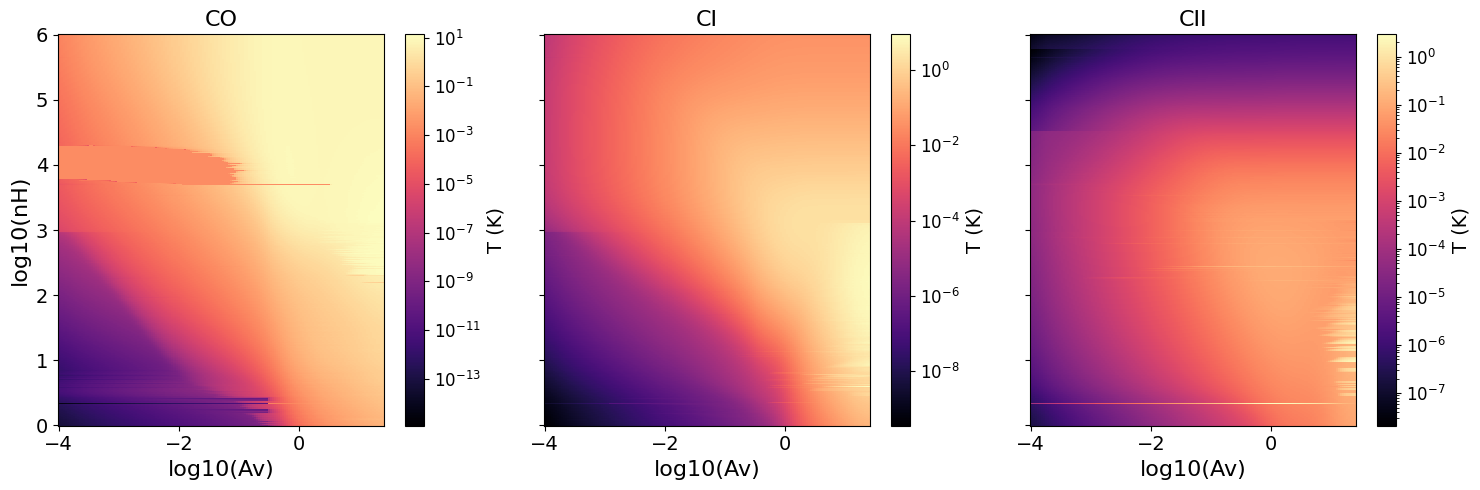

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)

p1 = ax[0].pcolor(lAvArr, lDensArr, TCO_grid, cmap='magma', norm=colors.LogNorm(), shading='auto')
p2 = ax[1].pcolor(lAvArr, lDensArr, TCI_grid, cmap='magma', norm=colors.LogNorm(), shading='auto')
p3 = ax[2].pcolor(lAvArr, lDensArr, TCII_grid, cmap='magma', norm=colors.LogNorm(), shading='auto')

ax[0].set_title("CO", fontsize=16)
ax[1].set_title("CI", fontsize=16)
ax[2].set_title("CII", fontsize=16)

ax[0].set_xlabel("log10(Av)", fontsize=16)
ax[1].set_xlabel("log10(Av)", fontsize=16)
ax[2].set_xlabel("log10(Av)", fontsize=16)

ax[0].set_ylabel("log10(nH)", fontsize=16)

for axi in ax:
    axi.tick_params(which='both', axis='both', labelsize=14)

cb1 = fig.colorbar(p1, ax=ax[0])
cb2 = fig.colorbar(p2, ax=ax[1])
cb3 = fig.colorbar(p3, ax=ax[2])

for cbi in [cb1, cb2, cb3]:
    cbi.ax.tick_params(labelsize=12)
    cbi.ax.set_ylabel("T (K)", fontsize=14)

plt.tight_layout()
plt.show()

In [6]:
dataDims = densDat.shape
Ndata = np.prod(dataDims)
print(dataDims)

(134, 284)


### Iterate through the map to get the synthetic images
Here, we iterate through the Taurus map to get the synthetic images. In order to do this, we pull the turbulent and gravitational densities, effective column density and the turbulent column density. We then use the 3D-PDR model to get the brightness temperatures for C+, C and CO lines. We assume as an approximation that for the diffuse gas the relevant attenuating columnn is the turbulent column density.

In [7]:
CO_image = np.zeros(dataDims)
CI_image = np.zeros(dataDims)
CII_image = np.zeros(dataDims)
temp_image = np.zeros(dataDims)

def sampEmiss_func(k):
    i = k // dataDims[1]
    j = k % dataDims[1]
    if (densDat[i,j] == 0) or (densDat[i,j] < densArr[0]):
        return 0.0, 0.0, 0.0, 0.0
    ldi = np.log10(densDat[i,j])
    ltdi = np.log10(tdensDat[i,j])
    avi = max(AvDat[i,j], AvArr[0])
    avi = min(avi, AvArr[-1])
    lav = np.log10(avi)
    tavi = max(TurbAv[i,j], AvArr[0])
    tavi = min(tavi, AvArr[-1])
    ltav = np.log10(tavi)
    
    tmpCO = splCO(ldi, lav)[0][0]
    tmpCI = splCI(ldi, lav)[0][0]
    tmpCII = splCII(ldi, lav)[0][0]

    tmpCI2 = splCI(ltdi, ltav)[0][0]
    if (ltdi > 2) and (ltdi < 3):
        tmpCII2 = 0.1
    else:
        tmpCII2 = splCII(ltdi, ltav)[0][0]
    tmpCO2 = splCO(ltdi, ltav)[0][0]

    tempG = splTemp(ldi, lav)[0][0]
    tempG2 = splTemp(ldi, ltav)[0][0]

    tmpCI = tmpCI  + tmpCI2
    tmpCII = tmpCII + tmpCII2
    tmpCO = tmpCO + tmpCO2
    tGas = (tmpCO * tempG + tmpCO2 * tempG2)/(tmpCO + tmpCO2)
    return tmpCO, tmpCI, tmpCII, tGas
    

with Pool(processes=nproc) as p:
    batno = 0
    numBatch = 10
    nBatch = Ndata // numBatch
    k = 0
    while batno < numBatch:
        lower = batno*nBatch
        upper = (batno+1)*nBatch
        if batno == numBatch-1:
            upper = Ndata
        results = list(
            tqdm.tqdm(
                p.imap(sampEmiss_func,
                    np.arange(lower, upper, 1), dataDims[1]),
                total=(upper - lower)
            )
        ) 
        for emiCO,emiCI,emiCII,tgasi in results:
            if (emiCO is None):
                k += 1
                import sys
                print("ERROR")
                sys.exit()
            i = k // dataDims[1]
            j = k % dataDims[1]
            CO_image[i,j] = emiCO
            CI_image[i,j] = emiCI
            CII_image[i,j] = emiCII
            temp_image[i,j] = tgasi
            k += 1
        del results
        batno += 1
    p.close()
    p.join()

100%|██████████| 3811/3811 [00:00<00:00, 4335365.49it/s]


### Plot the images

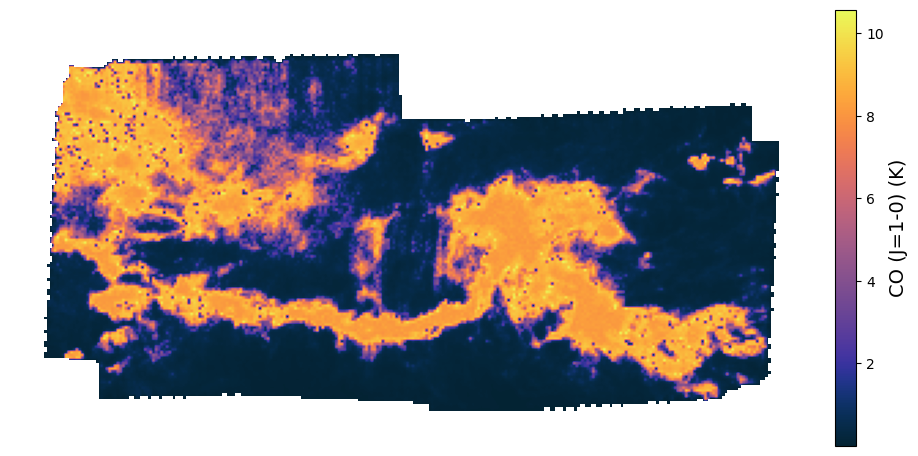

In [8]:
CO_img_plt = CO_image.copy()
CO_img_plt[densDat == 0] = np.nan
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(CO_img_plt, norm=colors.Normalize(vmin=1e-4), cmap=cmx.cm.thermal, origin='lower', rasterized=True)
ax.axis('off')
cb1 = fig.colorbar(im, shrink=0.45)
cb1.set_label("CO (J=1-0) (K)", fontsize=14)
plt.tight_layout()
plt.show()

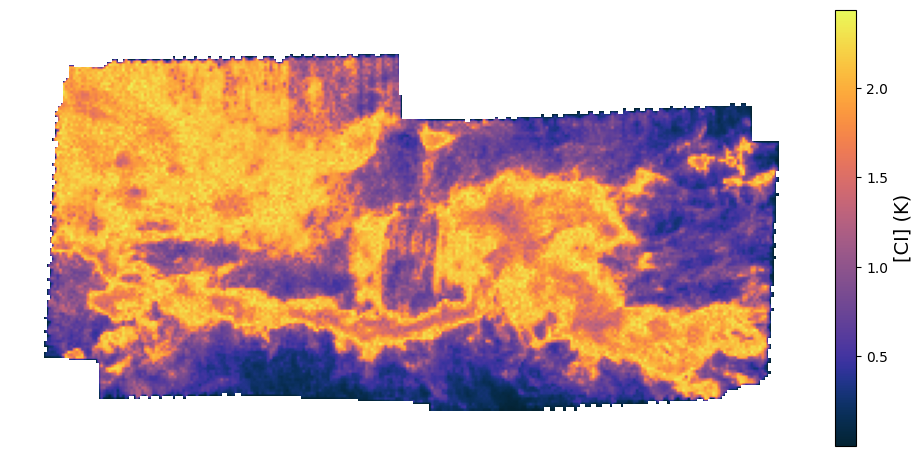

In [9]:
CI_img_plt = CI_image.copy()
CI_img_plt[densDat == 0] = np.nan
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(CI_img_plt, norm=colors.Normalize(), cmap=cmx.cm.thermal, origin='lower', rasterized=True)
ax.axis('off')
cb1 = fig.colorbar(im, shrink=0.45)
cb1.set_label("[CI] (K)", fontsize=14)
plt.tight_layout()
plt.show()

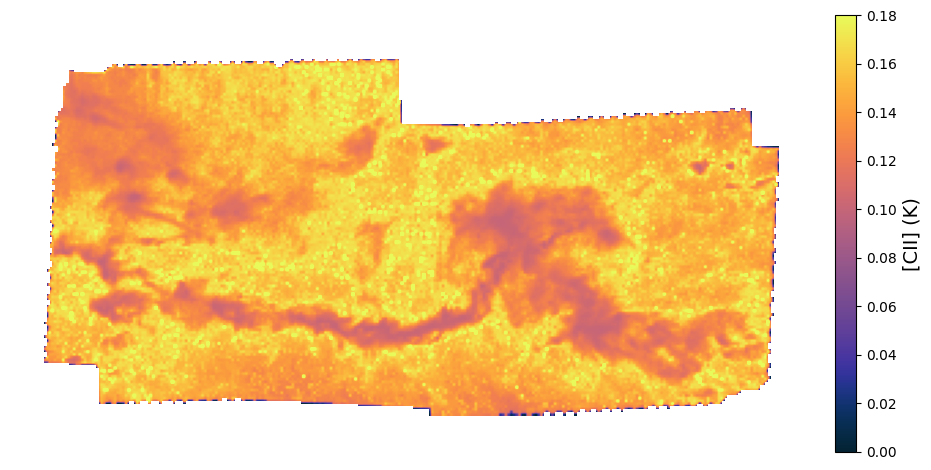

In [10]:
CII_img_plt = CII_image.copy()
CII_img_plt[densDat == 0] = np.nan
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(CII_img_plt, norm=colors.Normalize(vmin=0, vmax=0.18), cmap=cmx.cm.thermal, origin='lower', rasterized=True)
ax.axis('off')
cb1 = fig.colorbar(im, shrink=0.45)
cb1.set_label("[CII] (K)", fontsize=14)
plt.tight_layout()
plt.show()

### Save the images as numpy arrays for future use if needed

In [11]:
np.save("data/CO_image_taurus.npy", CO_image)
np.save("data/CI_image_taurus.npy", CI_image)
np.save("data/CII_image_taurus.npy", CII_image)

### Use astropy to make a decent looking RGB image of the three different lines. 
Note that the coefficients in the RGB image are fairly arbitrary and chosen to best make the image look representative of the data and artistic. Feel free to choose the balance of these yourself!

In [12]:
from astropy.visualization import make_lupton_rgb
datCO = np.load("data/CO_image_taurus.npy")
datCI = np.load("data/CI_image_taurus.npy")
datCII = np.load("data/CII_image_taurus.npy")

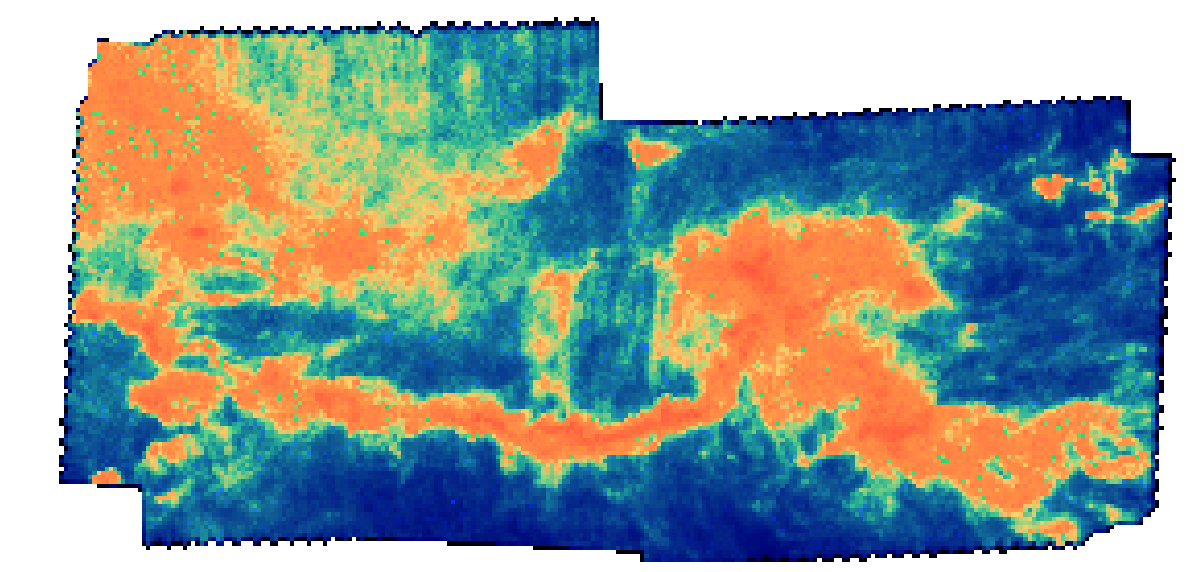

In [13]:
rgb_default = make_lupton_rgb(0.2*datCO, 0.5*datCI, 4*datCII, stretch=1.0, Q=2)


fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

rgb_default_plt = rgb_default.copy()
rgb_default_plt[datCO == 0] = [255,255,255]

ax.imshow(rgb_default_plt, origin='lower')  
ax.axis('off')
plt.tight_layout()
plt.show()